In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import allel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Import variants VCF file & Data Cleaning

In [2]:
vcf = allel.read_vcf("data/raw/1349 sample and all 253k unfiltered SNPs.vcf", )
variants = np.char.array(vcf["variants/CHROM"].astype(str)) + ":" + np.char.array(vcf["variants/POS"].astype(str))

In [3]:
vcf_arr = vcf["calldata/GT"].astype("float")
vcf_arr[vcf_arr == -1] = np.nan

In [4]:
mutations = vcf_arr
# mutations = np.abs(mutations)
mutations = mutations.sum(axis=2)
mutations = mutations.T
mutations.shape

(1349, 253708)

In [5]:
mutations_df = pd.DataFrame(data=mutations, index=vcf["samples"], columns=variants)
mutations_df.shape

(1349, 253708)

In [6]:
mutations_df.dropna(axis=1, how="any", thresh=800, inplace=True)
mutations_df.shape

(1349, 244975)

In [7]:
mutations_df.dropna(axis=0, how="any", thresh=200000, inplace=True)
mutations_df.fillna(value=0, inplace=True)

In [8]:
mutations_df.isna().sum().sum()

0

# Subset patients

In [9]:
samples_phenotypes = pd.read_table("data/raw/Sample metadata.csv", sep=",")
samples_phenotypes.set_index("ID", inplace=True)

In [10]:
good_samples = pd.read_table("data/interim/samples_metadata.csv", sep=",")
good_samples.set_index("ID", inplace=True)
good_samples = good_samples[good_samples["SRC"] != "LGS"]
good_samples = good_samples[good_samples["SRC"] != "D2"]
good_samples = good_samples[good_samples["SRC"] != "U2"]

In [11]:
SLE_samples = good_samples[good_samples["SLE"] == 1]
SLE_samples.shape

(634, 4)

In [12]:
hla_protein_samples = pd.Index(['55062', '56104', '34903', '16820', '41060', '54687', '44119', '48523',
       '33287', '14947', '21560', '87483', '42335', '30146', '28289', '40007'])

In [13]:
highdsdna_samples = pd.Index(["32588", "55062"]) # High dsDNA
lowdsdna_samples = pd.Index(["54687", "16820"]) # low dsDNA
validation_samples = highdsdna_samples.append(lowdsdna_samples)
validation_samples.shape

(4,)

In [14]:
training_samples = SLE_samples.index[~SLE_samples.index.isin(validation_samples)]
training_samples.shape

(630,)

# Filtered data

In [17]:
# filtered_df = mutations_df
filtered_df = mutations_df.filter(items=training_samples, axis=0)
filtered_df.shape

(630, 244975)

# Use PCA feature selction model

In [23]:
from src.features.PCA_feature_selection import PCA_Variants2Gene_FeatureSelection

In [24]:
pca_v2g = PCA_Variants2Gene_FeatureSelection(variants_genes_path="data/interim/variants_top56_genes.csv",
                 variance_threshold=0.80)

In [25]:
pca_v2g.fit_transform(filtered_df)

/Users/jonny/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


BANK1 top_k 285 (630, 6675)
BIK top_k 285 (630, 910)
BLK top_k 285 (630, 2935)


KeyboardInterrupt: 

# Subset variants by gene

In [47]:
variants_top56_genes = pd.read_table("../data/interim/variants_top56_genes.csv", sep=",")
variants_top56_genes.set_index("Variant ID", inplace=True)
variants_top56_genes = variants_top56_genes.filter(items=["Gene(s)", "Variant ID"])

In [75]:
genes_matched_variants = filtered_df.columns & variants_top56_genes.index

In [76]:
mutations_gene_matched = filtered_df.T.join(variants_top56_genes, how="right")

In [78]:
mutations_by_gene = {}
mutations_gene_gb = mutations_gene_matched.groupby("Gene(s)")
for x in mutations_gene_gb.groups:
    mutations_gene_df = mutations_gene_gb.get_group(x)
    gene_name = mutations_gene_df["Gene(s)"].iloc[0]
    print(gene_name)
    mutations_gene_df = mutations_gene_df.drop(columns=["Gene(s)"]).dropna(axis=0).T
#     mutations_gene_df.to_csv("../data/processed/SNPs_by_gene/"+gene_name+".csv")
    mutations_by_gene[gene_name] = mutations_gene_df

BANK1
BIK
BLK
BTNL2
CDHR5
CEP70
CHD7
CNTNAP2
DAP
DAPK1
DSCAM
DSCAML1
ETS1
FAIM
GSDMB
HLA-DOB
HLA-DQA1
HLA-DQA2
HLA-DQB1
HLA-DQB2
HLA-DRA
HLA-DRB1
HLA-DRB5
ICA1
ICAM1
IKZF3
IRF5
IRF8
ITGAM
ITGAX
MECP2
NMNAT2
PHRF1
PRDM1
PXK
RAVER1
ROBO3
ROBO4
SCUBE1
SMG7
STAT4
TAP2
TLR7
TNFAIP3
TNFRSF13B
TNFSF4
TNIP1
TNPO3
TSPO
TTLL12
TYK2
UBE2L3
XKR6


# Gene - mutations

In [66]:
variant_genes = pd.read_table("../data/raw/216k Variants with gene name.csv", sep=",")
variant_genes = variant_genes[variant_genes["Gene(s)"] != "?"]
# variant_genes = variant_genes.filter(items=["Gene(s)", "Variant ID"])
variant_genes["Position"] = variant_genes["Position"].astype("object")

In [73]:
genes_56 = variant_genes["Gene(s)"].value_counts()[:56]

# Run PCA

In [79]:
def get_top_k_components(snp_data, var_threshold=0.80, return_fit_transform=False):
    pca = PCA()
    pca.fit(snp_data)
    top_k = np.argmax(np.cumsum(np.power(pca.singular_values_, 2)) /
                      np.sum(np.power(pca.singular_values_, 2)) > var_threshold)

    if return_fit_transform:
        pca.n_components = top_k
        pca.n_components_ = top_k
        return pca.transform(snp_data)[:, :top_k]
    else:
        return pca.components_[:top_k]

def get_top_variant_by_coef(pca_components, coef_percentile=70):
    gene_coefs_sum = np.abs(pca_components).sum(axis=0)
    coefs_percentile = np.percentile(gene_coefs_sum, coef_percentile)
    return np.where(gene_coefs_sum > coefs_percentile)

def select_top_variants(snp_data, var_threshold=0.80, coef_percentile=70):
    variants = snp_data.columns
    top_k_components = get_top_k_components(snp_data, var_threshold)
    top_variants_idx = get_top_variant_by_coef(top_k_components, coef_percentile)

    return variants[top_variants_idx]

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Variant coefficients from PCA top-k components feature selection for "+gene)
plt.ylabel("coefficient")
plt.xlabel("genes")
plt.scatter(x=range(pca.components_.shape[1]), y=gene_coefs_sum)

# Compute PCA projections of all SNP data

In [81]:
pca_projs_by_gene = {}
for gene in mutations_by_gene.keys():
    pca_projs_by_gene[gene] = get_top_k_components(mutations_by_gene[gene], 
                                                   var_threshold=0.90,
                                                   return_fit_transform=True)
    print(gene, mutations_by_gene[gene].shape[1],  pca_projs_by_gene[gene].shape)

BANK1 6675 (634, 105)
BIK 910 (634, 62)
BLK 2935 (634, 54)
BTNL2 968 (634, 21)
CDHR5 336 (634, 39)
CEP70 954 (634, 57)
CHD7 2424 (634, 47)
CNTNAP2 2418 (634, 78)
DAP 2002 (634, 41)
DAPK1 6786 (634, 135)
DSCAM 3100 (634, 83)
DSCAML1 996 (634, 37)
ETS1 2882 (634, 90)
FAIM 971 (634, 73)
GSDMB 665 (634, 40)
HLA-DOB 129 (634, 9)
HLA-DQA1 1275 (634, 59)
HLA-DQA2 491 (634, 13)
HLA-DQB1 1578 (634, 63)
HLA-DQB2 473 (634, 14)
HLA-DRA 263 (634, 12)
HLA-DRB1 3290 (634, 133)
HLA-DRB5 3237 (634, 160)
ICA1 4127 (634, 112)
ICAM1 939 (634, 99)
IKZF3 3645 (634, 127)
IRF5 394 (634, 22)
IRF8 668 (634, 13)
ITGAM 2813 (634, 103)
ITGAX 1014 (634, 44)
MECP2 2688 (634, 149)
NMNAT2 5770 (634, 114)
PHRF1 1681 (634, 77)
PRDM1 545 (634, 17)
PXK 3963 (634, 93)
RAVER1 702 (634, 49)
ROBO3 349 (634, 21)
ROBO4 330 (634, 16)
SCUBE1 4577 (634, 120)
SMG7 1916 (634, 52)
STAT4 2737 (634, 80)
TAP2 548 (634, 23)
TLR7 597 (634, 37)
TNFAIP3 303 (634, 5)
TNFRSF13B 1210 (634, 64)
TNFSF4 538 (634, 15)
TNIP1 1628 (634, 36)
TNPO3 39

<BarContainer object of 53 artists>

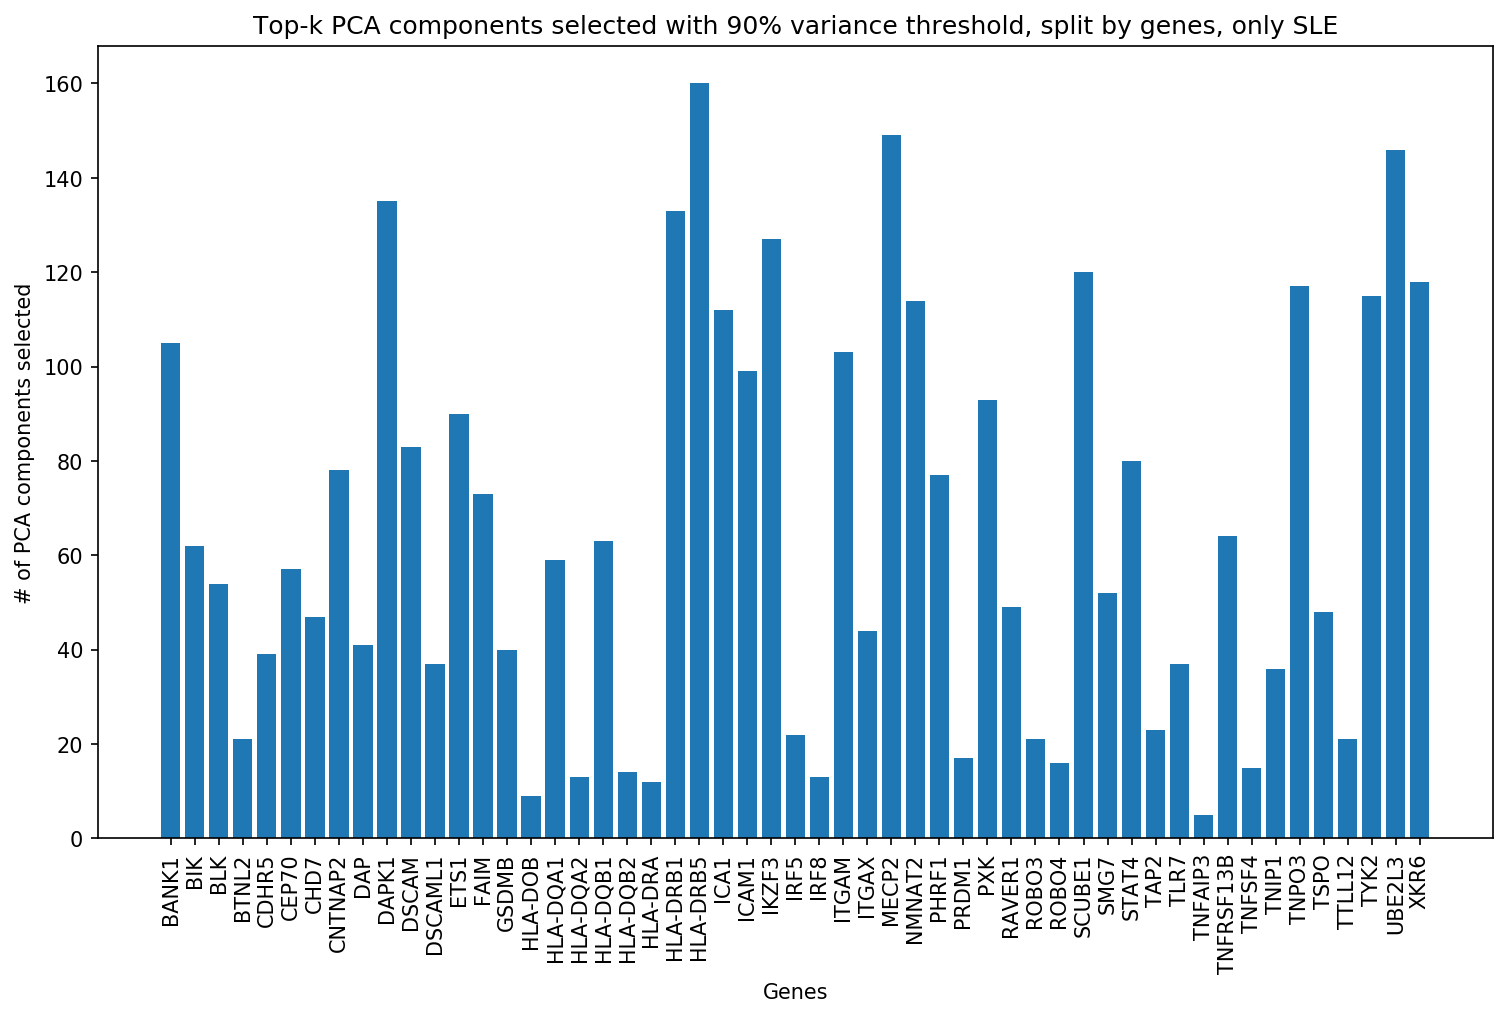

In [83]:
genes = list(pca_projs_by_gene.keys())
num_top_components = [pca_projs_by_gene[gene].shape[1] for gene in genes]
plt.figure(figsize=(12, 7), dpi=150)
plt.title("Top-k PCA components selected with 90% variance threshold, split by genes, only SLE")
plt.xlabel("Genes")
plt.xticks(rotation=90)
plt.ylabel("# of PCA components selected")
plt.bar(x=genes, height=num_top_components)

In [166]:
pca_projs_concat = np.concatenate([pca_projs_by_gene[gene] for gene in pca_projs_by_gene.keys()],
                                 axis=1)
pca_projs_concat.shape

(1127, 15980)

In [169]:
pca_proj_names = []
for i, gene in enumerate(mutations_by_gene.keys()):
    for n in range(num_top_components[i]):
         pca_proj_names.append(gene + "_" + str(n))
len(pca_proj_names)

10575

In [168]:
pca_projs_concat_df = pd.DataFrame(pca_projs_concat, index=mutations_gene_df.index, columns=pca_proj_names)
pca_projs_concat_df.index.name = "Sample ID"

ValueError: Shape of passed values is (1127, 15980), indices imply (1127, 10575)

In [144]:
patient_gene_proj_scores = pd.DataFrame(index=pca_projs_concat_df.index, columns=genes)

for gene in genes:
    projs_by_gene = pca_projs_concat_df.iloc[:, pca_projs_concat_df.columns.str.contains(gene)]
    patient_gene_proj_scores[gene] = np.power(projs_by_gene, 2).sum(axis=1)/projs_by_gene.columns.shape[0]

In [145]:
patient_gene_proj_scores

,BANK1,BIK,BLK,BTNL2,CDHR5,CEP70,CHD7,CNTNAP2,DAP,DAPK1,...,TNFAIP3,TNFRSF13B,TNFSF4,TNIP1,TNPO3,TSPO,TTLL12,TYK2,UBE2L3,XKR6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Betty_Ill_4901_2,0.809474,0.479510,0.743162,0.970505,0.060524,0.068643,0.404527,0.573658,0.785266,1.221183,...,0.112997,0.235669,0.538472,0.272223,0.604225,0.640360,1.017127,0.449058,0.526472,1.628768
ucl223ILL1,1.223338,0.105189,0.925351,1.719975,0.109509,0.313414,1.739810,0.325379,1.933328,3.008968,...,0.352428,0.210859,0.350547,0.511407,0.613192,0.102948,0.303651,0.180382,0.541667,1.761100
Betty_Ill_3822_2,0.719220,0.162243,0.818166,0.343822,0.040570,0.299656,0.327366,0.410006,0.854593,1.285327,...,0.087790,0.307093,0.371443,0.491633,0.557684,0.335739,0.953208,0.210236,0.442091,2.988263
Betty_Ill_5103_2,1.296147,0.073125,0.238694,0.494056,0.064558,0.096801,0.356770,0.470179,0.801289,1.236076,...,0.288416,0.327325,0.206206,0.569323,0.544394,0.345916,0.772304,0.258980,0.511670,1.140355
Betty_Ill_1045_2,1.029908,0.159404,0.788404,0.684585,0.078699,0.081308,0.318829,0.376723,1.008886,1.543668,...,0.388319,0.361804,0.468867,0.457276,0.564898,0.345185,0.814385,0.342020,0.663334,1.618242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,2.061822,0.451081,0.878921,1.070708,0.220643,0.355156,0.568773,0.906408,1.684776,2.027510,...,0.402172,0.411129,0.648711,0.826498,1.155834,0.401217,0.462875,1.220084,0.815404,2.693893
57739,1.983748,0.411565,0.833145,0.571685,0.057062,0.448527,0.671546,0.880180,1.368353,2.109798,...,0.415054,0.988594,1.034811,0.347300,1.250365,0.364095,0.639646,0.555541,1.045926,1.869671
1561,1.052550,0.482508,0.541377,0.729623,0.092662,0.209166,0.501401,0.627381,1.384427,2.081192,...,0.091457,1.053527,0.516954,0.574756,1.585443,0.395316,0.884703,0.583642,1.766174,1.664315


In [146]:
patient_gene_proj_scores.to_csv("../data/interim/patient_gene_proj_scores.csv")

In [147]:
pca_projs_concat_df

,BANK1_0,BANK1_1,BANK1_2,BANK1_3,BANK1_4,BANK1_5,BANK1_6,BANK1_7,BANK1_8,BANK1_9,...,XKR6_290,XKR6_291,XKR6_292,XKR6_293,XKR6_294,XKR6_295,XKR6_296,XKR6_297,XKR6_298,XKR6_299
Sample ID,,,,,,,,,,,,,,,,,,,,,
Betty_Ill_4901_2,-3.622873,-4.328217,-2.868676,2.585993,4.963758,-4.421878,-5.133312,-4.987797,2.523739,-1.502999,...,-0.025093,0.313438,0.058648,-0.046331,0.093543,0.100586,0.885550,-0.386735,0.540631,0.151420
ucl223ILL1,8.269332,-4.780259,11.086978,-1.050687,-5.425807,-1.089494,-0.425643,3.843408,2.292642,2.838494,...,-0.135010,0.292714,0.251496,0.223141,-0.223100,0.268978,0.187660,0.046543,-0.121860,0.234417
Betty_Ill_3822_2,-2.464936,-2.785070,4.354677,5.089163,5.816925,3.491054,-1.794400,-4.381879,0.991313,1.041675,...,-0.141523,0.339197,0.272268,-0.009190,0.410784,-0.263101,-0.077068,0.022368,-0.329014,-0.322536
Betty_Ill_5103_2,11.836786,-5.121265,-3.533660,2.570362,-4.108086,0.220169,3.581049,1.813212,-3.197353,-3.998905,...,-0.014621,0.398026,0.104101,0.259476,0.250601,0.471707,-0.215751,-0.292953,0.076340,0.140190
Betty_Ill_1045_2,8.695288,-3.450556,-1.798358,-3.612374,-7.173920,-1.434277,6.271253,0.038209,2.759469,3.467289,...,-0.537052,-0.318202,-0.116223,-0.012839,-0.071218,-0.009122,0.103368,0.136204,-0.419366,-0.149271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,8.766711,-3.194188,7.894603,4.924313,-0.754601,4.347345,0.583879,1.185305,-4.699086,-0.225583,...,0.202350,0.199448,-0.183495,0.017232,0.093409,-0.038641,-0.059214,-0.178434,-0.291047,0.215530
57739,-7.334010,-1.336158,-2.404411,-11.451477,0.398472,-1.854993,-2.290910,2.219272,-1.671402,2.825856,...,0.197554,-0.149821,-0.450912,0.350083,1.179558,0.072835,0.631099,-0.141279,0.160997,0.106603
1561,3.628764,-4.619030,2.252791,-0.623261,0.065576,-2.086006,-0.268979,-0.831656,-2.970468,0.308540,...,-0.563037,0.412448,-0.317984,-0.244853,0.097530,-0.183373,-0.008907,-0.142303,0.330258,0.154015


In [148]:
pca_projs_concat_df.to_csv("../data/interim/PCA_projections_80_variance_SLE_samples.csv", 
                             index=True)

# Select variants by percentile

In [172]:
top_variants_by_gene = {}
for gene in mutations_by_gene.keys():
    top_variants_by_gene[gene] = select_top_variants(mutations_by_gene[gene], var_threshold=0.80, coef_percentile=70)
    print(gene, mutations_by_gene[gene].shape[1],  top_variants_by_gene[gene].shape[0])

BANK1 6828 2049
BIK 911 273
BLK 2937 881
BTNL2 968 290
CDHR5 338 102
CEP70 972 292
CHD7 2429 729
CNTNAP2 2484 745
DAP 2011 603
DAPK1 6835 2051
DSCAM 3179 954
DSCAML1 998 300
ETS1 2889 867
FAIM 994 298
GSDMB 685 206
HLA-DOB 129 39
HLA-DQA1 1275 383
HLA-DQA2 492 148
HLA-DQB1 1578 474
HLA-DQB2 473 142
HLA-DRA 263 79
HLA-DRB1 3409 1023
HLA-DRB5 3760 1127
ICA1 4165 1250
ICAM1 1043 313
IKZF3 3781 1134
IRF5 397 119
IRF8 668 201
ITGAM 2982 895
ITGAX 1057 317
MECP2 2902 871
NMNAT2 5815 1745
PHRF1 1800 540
PRDM1 545 163
PXK 3989 1197
RAVER1 755 227
ROBO3 351 105
ROBO4 330 99
SCUBE1 4588 1377
SMG7 1941 582
STAT4 2755 827
TAP2 548 165
TLR7 597 179
TNFAIP3 305 92
TNFRSF13B 1214 364
TNFSF4 538 162
TNIP1 1628 489
TNPO3 4060 1218
TSPO 633 190
TTLL12 890 267
TYK2 2155 647
UBE2L3 4022 1207
XKR6 10417 3125


In [176]:
all_top_variants = []
for gene in top_variants_by_gene.keys():
    all_top_variants.extend(top_variants_by_gene[gene])
len(all_top_variants)

34122

# Concatenate all selected variant into one DataFrame

In [182]:
mutations_df = mutations_df.loc[:,~mutations_df.columns.duplicated()]

In [183]:
mutations_top_variants_df = mutations_df.filter(items=all_top_variants)

In [184]:
mutations_top_variants_df

,4:102711068,4:102712657,4:102713097,4:102713410,4:102713410,4:102713412,4:102713412,4:102713419,4:102713419,4:102713419,...,8:11058039,8:11058071,8:11058203,8:11058345,8:11058400,8:11058400,8:11058478,8:11058479,8:11058892,8:11058990
Betty_Ill_4901_2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,2,0
ucl223ILL1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,0
Betty_Ill_3822_2,0,1,0,0,0,1,1,0,0,0,...,0,2,0,0,0,0,0,0,2,0
CKG1996ILL1,0,2,1,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,0
Betty_Ill_5103_2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57739,0,0,0,0,0,0,0,0,0,0,...,0,2,2,2,2,2,2,2,2,2
1561,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
2546,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,0,2,2,2,2
686-1,0,1,1,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [185]:
mutations_top_variants_df.to_csv("../data/interim/mutations_top_variants_80_variance.csv")

# Graph the eigenvalues

In [109]:
import matplotlib.pyplot as plt

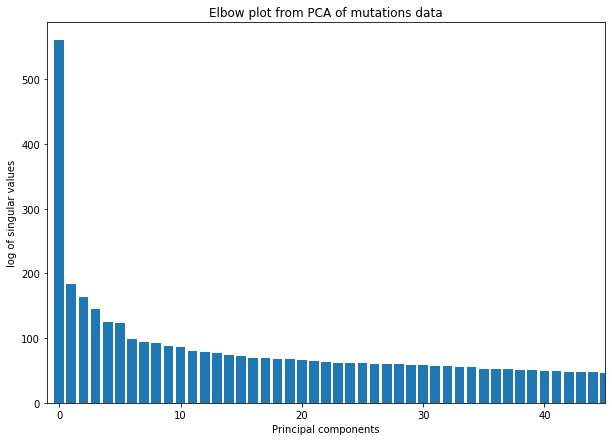

In [113]:
plt.figure(figsize=(10, 7))
plt.bar(x=range(pca.singular_values_.shape[0]), 
        height=pca.singular_values_, )

plt.ylabel('log of singular values')
plt.xlabel('Principal components')
plt.title('Elbow plot from PCA of mutations data')
plt.xlim(-1, 45)
# plt.ylim(0, 10)
plt.show()